#### Extract 100 Sequences per Biotype

In [1]:
import gzip
from collections import defaultdict
from Bio import SeqIO

# Path to input FASTA file
input_fasta = "genomic_embeddings_data/biotypes/gencode.v44.transcripts.fa.gz"
output_fasta = "genomic_embeddings_data/biotypes/gencode.v44.transcripts.fa"

# Target number of sequences per biotype
N = 100

# Dictionary to hold sequences by biotype
biotype_seqs = defaultdict(list)

# Open and parse the gzipped FASTA
with gzip.open(input_fasta, "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        header = record.description
        # Example header:
        # >ENST00000456328.2|ENSG00000223972.5|OTTHUMG00000000961.2|OTTHUMT00000002844.2|DDX11L1-202|DDX11L1|245|lncRNA|...
        fields = header.split("|")
        if len(fields) >= 8:
            biotype = fields[7]
            if len(biotype_seqs[biotype]) < N:
                biotype_seqs[biotype].append(record)

# Write to output FASTA
with open(output_fasta, "w") as out_fh:
    for biotype, records in biotype_seqs.items():
        SeqIO.write(records, out_fh, "fasta")

print(f"Saved sequences for {len(biotype_seqs)} biotypes in '{output_fasta}'")


Saved sequences for 45 biotypes in 'genomic_embeddings_data/biotypes/gencode.v44.transcripts.fa'


#### Extract all protein coding and lncRNA sequences

In [2]:
import gzip
from Bio import SeqIO

# Input FASTA file path
input_fasta = "genomic_embeddings_data/biotypes/gencode.v44.transcripts.fa.gz"

# Output FASTA file
output_fasta = "genomic_embeddings_data/biotypes/gencode.v44.100_protein_coding_and_100_lncRNA.fa"

# Biotypes of interest and counters
target_biotypes = {"protein_coding", "lncRNA"}
biotype_counts = {"protein_coding": 0, "lncRNA": 0}
biotype_limits = {"protein_coding": 100, "lncRNA": 100}

# Store matching sequences
matching_records = []

with gzip.open(input_fasta, "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        header = record.description
        fields = header.split("|")
        if len(fields) >= 8:
            biotype = fields[7]
            if (
                biotype in target_biotypes and
                biotype_counts[biotype] < biotype_limits[biotype]
            ):
                matching_records.append(record)
                biotype_counts[biotype] += 1

        # Stop early if both limits are met
        if all(biotype_counts[b] >= biotype_limits[b] for b in target_biotypes):
            break

# Write output
with open(output_fasta, "w") as out_fh:
    SeqIO.write(matching_records, out_fh, "fasta")

print(f"Saved {len(matching_records)} sequences to {output_fasta}")


Saved 200 sequences to genomic_embeddings_data/biotypes/gencode.v44.100_protein_coding_and_100_lncRNA.fa


#### Process using HyenaDNA and plot the visualization 

##### Load model and tokenizer

In [23]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from Bio import SeqIO
import umap
import matplotlib.pyplot as plt
import numpy as np
import einops

# Load model and tokenizer
#model_name = "zhihan1996/DNABERT-2-117M"
#model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
model_name = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(model_name, trust_remote_code=True)

##### Load FASTA sequences

In [24]:
# Load FASTA sequences
fasta_file =  "genomic_embeddings_data/biotypes/gencode.v44.100_protein_coding_and_100_lncRNA.fa"
records = list(SeqIO.parse(fasta_file, "fasta"))

# Extract labels based on biotype from header
labels = []
sequences = []

for record in records:
    fields = record.description.split("|")
    if len(fields) >= 8:
        biotype = fields[7]
        labels.append(biotype)
        sequences.append(str(record.seq).upper().replace("U", "T"))  # DNA only

# Encode and embed sequences
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4105, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1002, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-23): 24 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
          )
          (int

In [25]:
!nvidia-smi

Mon May 26 01:24:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:3D:00.0 Off |                    0 |
| N/A   36C    P0             58W /  300W |   32438MiB /  32768MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Compute Embeddings

Use below for Nucleotide Transformer

In [38]:
full_sequences = sequences
sequences = [seq[:250] for seq in sequences]
tokens = tokenizer(sequences, return_tensors="pt", padding=True, truncation=True)
tokens = {key: val.to(device) for key, val in tokens.items()}

# Forward pass with hidden states
with torch.no_grad():
    outputs = model(**tokens, output_hidden_states=True)
    last_hidden_state = outputs.hidden_states[-1]  # (batch_size, seq_len, hidden_dim)

# Mean pooling
attention_mask = tokens["attention_mask"].unsqueeze(-1)  # (batch_size, seq_len, 1)
masked_embeddings = last_hidden_state * attention_mask
sum_embeddings = masked_embeddings.sum(dim=1)
lengths = attention_mask.sum(dim=1)
mean_embeddings = sum_embeddings / lengths

# Convert to NumPy
embeddings = mean_embeddings.cpu().numpy()

print("Embeddings shape:", embeddings.shape)

Embeddings shape: (200, 1280)


##### Plot Embeddings using UMAP

/biocorelab/BIX/util/miniconda3/envs/new-llm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/biocorelab/BIX/util/miniconda3/envs/new-llm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


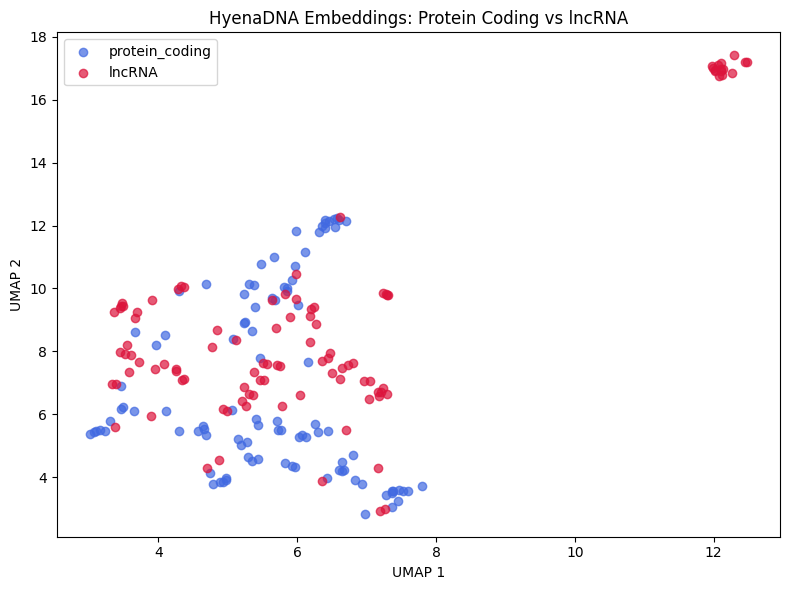

In [39]:
# Run UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine", random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
colors = {"protein_coding": "royalblue", "lncRNA": "crimson"}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_umap[idx, 0], embeddings_umap[idx, 1],
                label=label, alpha=0.7, color=colors.get(label, "gray"))

plt.legend()
plt.title("HyenaDNA Embeddings: Protein Coding vs lncRNA")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

/biocorelab/BIX/util/miniconda3/envs/new-llm/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


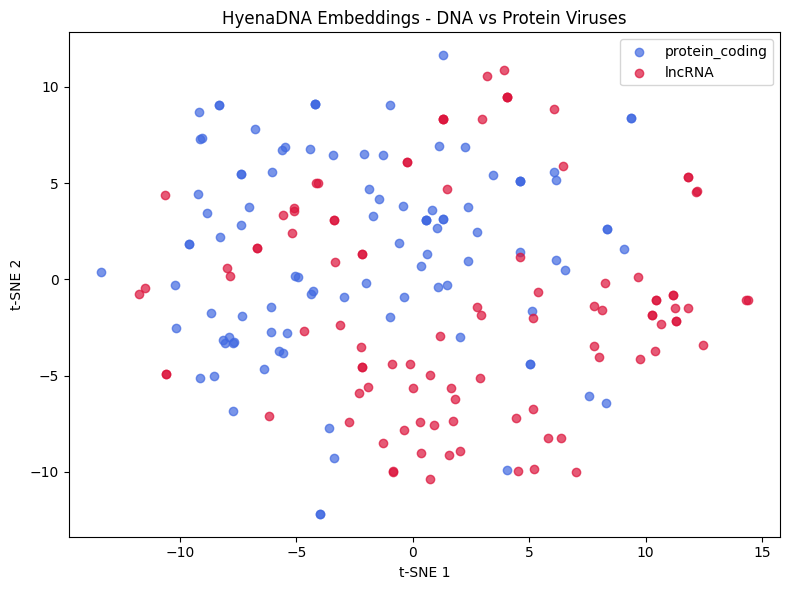

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


# Plot
plt.figure(figsize=(8, 6))
colors = ["royalblue", "crimson"]
for i, label in enumerate(set(labels)):
    idx = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label, alpha=0.7, color=colors[i])
plt.legend()
plt.title("HyenaDNA Embeddings - DNA vs Protein Viruses")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()